In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pymc3 as pm

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)


Utility Functions

In [2]:
def dist(*vec):
    return np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

def cartesian(*dims):
    return np.array(np.meshgrid(*dims, indexing='ij')).T.reshape(-1, len(dims))

def add_noise(input, sc=.1, *args, **kwargs):
    # Wrapper to add Gaussian noise to array
    return input + norm.rvs(size=input.shape, scale=input.std()*sc, *args, **kwargs)

Define model function for hologram.

A tip to remember here is that you should avoid idioms involving iterables. While numpy array, lists, etc, are iterable over their elements, theno object are not in general and thus will cause trouble when used by pymc3 as a model. This is why I have lines like `re_m, im_m = m[0], m[1]` instead of simply `re_m, im_m = m`... it's because when m is a theano varible with two components, Python somehow does not know how to iterate over m! (There must be a better way...

Also some numpy functions are not supported automatically by theano. (For example, I have to use numpy.arctan instead of numpy.arctan2)

In [3]:
def rayleigh_gans_sphere_holo(position, k, center, m, a):
    r = (position-center).T
    r = dist(r[0], r[1], r[2])
    
    z = center[2]
    theta = np.arccos(z/r)
    
    V = 4/3*np.pi*a**3
    
    x = k*a
    u = 2*x*np.sin(.5*theta)
    G = 3 / u**3 * (np.sin(u) - u * np.cos(u))
    
    re_m, im_m = m[0], m[1]
    
    S2_mag = k**3 * a**3 * np.sqrt(re_m*re_m + im_m*im_m - 2*re_m + 1) * 2/3 * np.cos(theta) * G
    #S2_phase = np.arctan2(re_m - 1, im_m)
    S2_phase = np.arctan((re_m - 1)/im_m)
    
    holo_scatt = (1/(k*r)*S2_mag)**2
    holo_inter = 2 * 1/(k*r) * S2_mag * np.sin(k*(r-z) + S2_phase)
    
    # Techinically, the full pattern would have a term that would go as the intensity of the incident wave
    # but here I am subtracting it off this uninteresting DC term (for precision).
    holo_full = holo_scatt + holo_inter  #+ 1 
    
    return holo_full

Generate some test data:

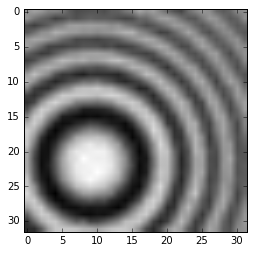

In [4]:
resolution = 32
x = y = np.linspace(0, 10, resolution)
z = 0

grid = cartesian(x, y, z)

illum_wavelength = 1.0
illum_wavenumber = 2*np.pi/illum_wavelength
sc_center = np.array([3, 7, 5])
sc_index = np.array([1.15, 0])
sc_radius = illum_wavelength/10

clean_data = rayleigh_gans_sphere_holo(grid, illum_wavenumber, sc_center, sc_index, sc_radius)
data = add_noise(clean_data)
plt.gray()
plt.imshow(data.reshape((resolution,resolution)))
plt.show()

Use pymc3 to infer point scatterer position and the ratio of the referece wave amplitude to the scattered wave amplitude (which I think corresponds to the index of refraction for a macroscopic object). Of course the choices of priors affect the results.

In [7]:
with pm.Model() as RGScatterer:
    center = pm.Uniform('Scatterer location', lower=0, upper=10, shape=3)
    index = pm.Uniform('Scatterer index of refraction', lower=0, upper=2, shape=2)
    radius = pm.Uniform('Scaterer radius', lower=0, upper=illum_wavelength*10)
    
    expectedvalue = rayleigh_gans_sphere_holo(grid, illum_wavenumber, center, index, radius)
    likelihood = pm.Normal('likelihood', mu=expectedvalue, sd=data.std(), observed=data)

In [ ]:
with RGScatterer:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(256, step=step, start=start)

         Current function value: -5524.624168
         Iterations: 14
         Function evaluations: 42
         Gradient evaluations: 32



  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

In [ ]:
pm.traceplot(trace)
print('\a')

In [8]:
nuts_center = trace.get_values('Scatterer location').mean(axis=0)
print(nuts_center)
nuts_n = trace.get_values('N').mean()
print(nuts_n)

[ 3.00161033  6.99762827  5.00088194]
0.0522462965592


Below is the original hologram, the hologram with noise added (raw data), and a "reconstructed" hologram calculated from parameters inferred by pymc3 from the noisy hologram.

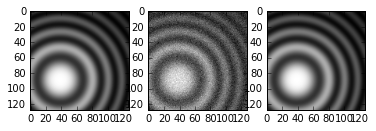

In [9]:
plt.subplot(1, 3, 1)
plt.imshow(clean_data.reshape((resolution, resolution)))
plt.subplot(1, 3, 2)
plt.imshow(data.reshape((resolution, resolution)))
plt.subplot(1, 3, 3)
plt.imshow(point_holo(grid, nuts_center, wavevector, nuts_n).reshape(resolution, resolution))
plt.show()